## Getting Started
Concord integrates seamlessly with `anndata` objects. 
Single-cell datasets, such as 10x Genomics outputs, can easily be loaded into an `annData` object using the [`Scanpy`](https://scanpy.readthedocs.io/) package. If you're using R and have data in a `Seurat` object, you can convert it to `anndata` format by following this [tutorial](https://qinzhu.github.io/Concord_documentation/). 
In this quick-start example, we'll demonstrate CONCORD using the `pbmc3k` dataset provided by the `scanpy` package.

### Load package and data

In [1]:
# Load required packages
import Concord as ccd
import scanpy as sc
import torch
# Load and prepare example data
adata = sc.datasets.pbmc3k_processed()
adata = adata.raw.to_adata()  # Store raw counts in adata.X, by default Concord will run standard total count normalization and log transformation internally, not necessary if you want to use your normalized data in adata.X, if so, specify 'X' in cur_ccd.encode_adata(input_layer_key='X', output_key='Concord')

### Run CONCORD

In [2]:
# Set device to cpu or to gpu (if your torch has been set up correctly to use GPU), for mac you can use either torch.device('mps') or torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# (Optional) Select top variably expressed/accessible features for analysis (other methods besides seurat_v3 available)
feature_list = ccd.ul.select_features(adata, n_top_features=5000, flavor='seurat_v3')

# Initialize Concord with an AnnData object, skip input_feature to use all features
cur_ccd = ccd.Concord(adata=adata, input_feature=feature_list, device=device) 

# If integrating data across batch, simply add the domain_key argument to indicate the batch key in adata.obs
# cur_ccd = ccd.Concord(adata=adata, input_feature=feature_list, domain_key='batch', device=device) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
cur_ccd.encode_adata(output_key='Concord')

Concord.utils.feature_selector - INFO - Selecting highly variable features with flavor seurat_v3...
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


/opt/anaconda3/envs/concord/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


p_intra_knn: 0.3


Epoch 0 Training: 41it [00:00, 82.30it/s, loss=4.07]
Epoch 9 Training: 100%|██████████| 41/41 [00:00<00:00, 152.19it/s, loss=3.71]


### Visualization

CONCORD latent embeddings can be directly used for downstream analyses such as visualization with UMAP and t-SNE or constructing k-nearest neighbor (kNN) graphs. Unlike PCA, it is important to utilize the full CONCORD latent embedding in downstream analyses, as each dimension is designed to capture meaningful and complementary aspects of the underlying data structure.

/opt/anaconda3/envs/concord/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


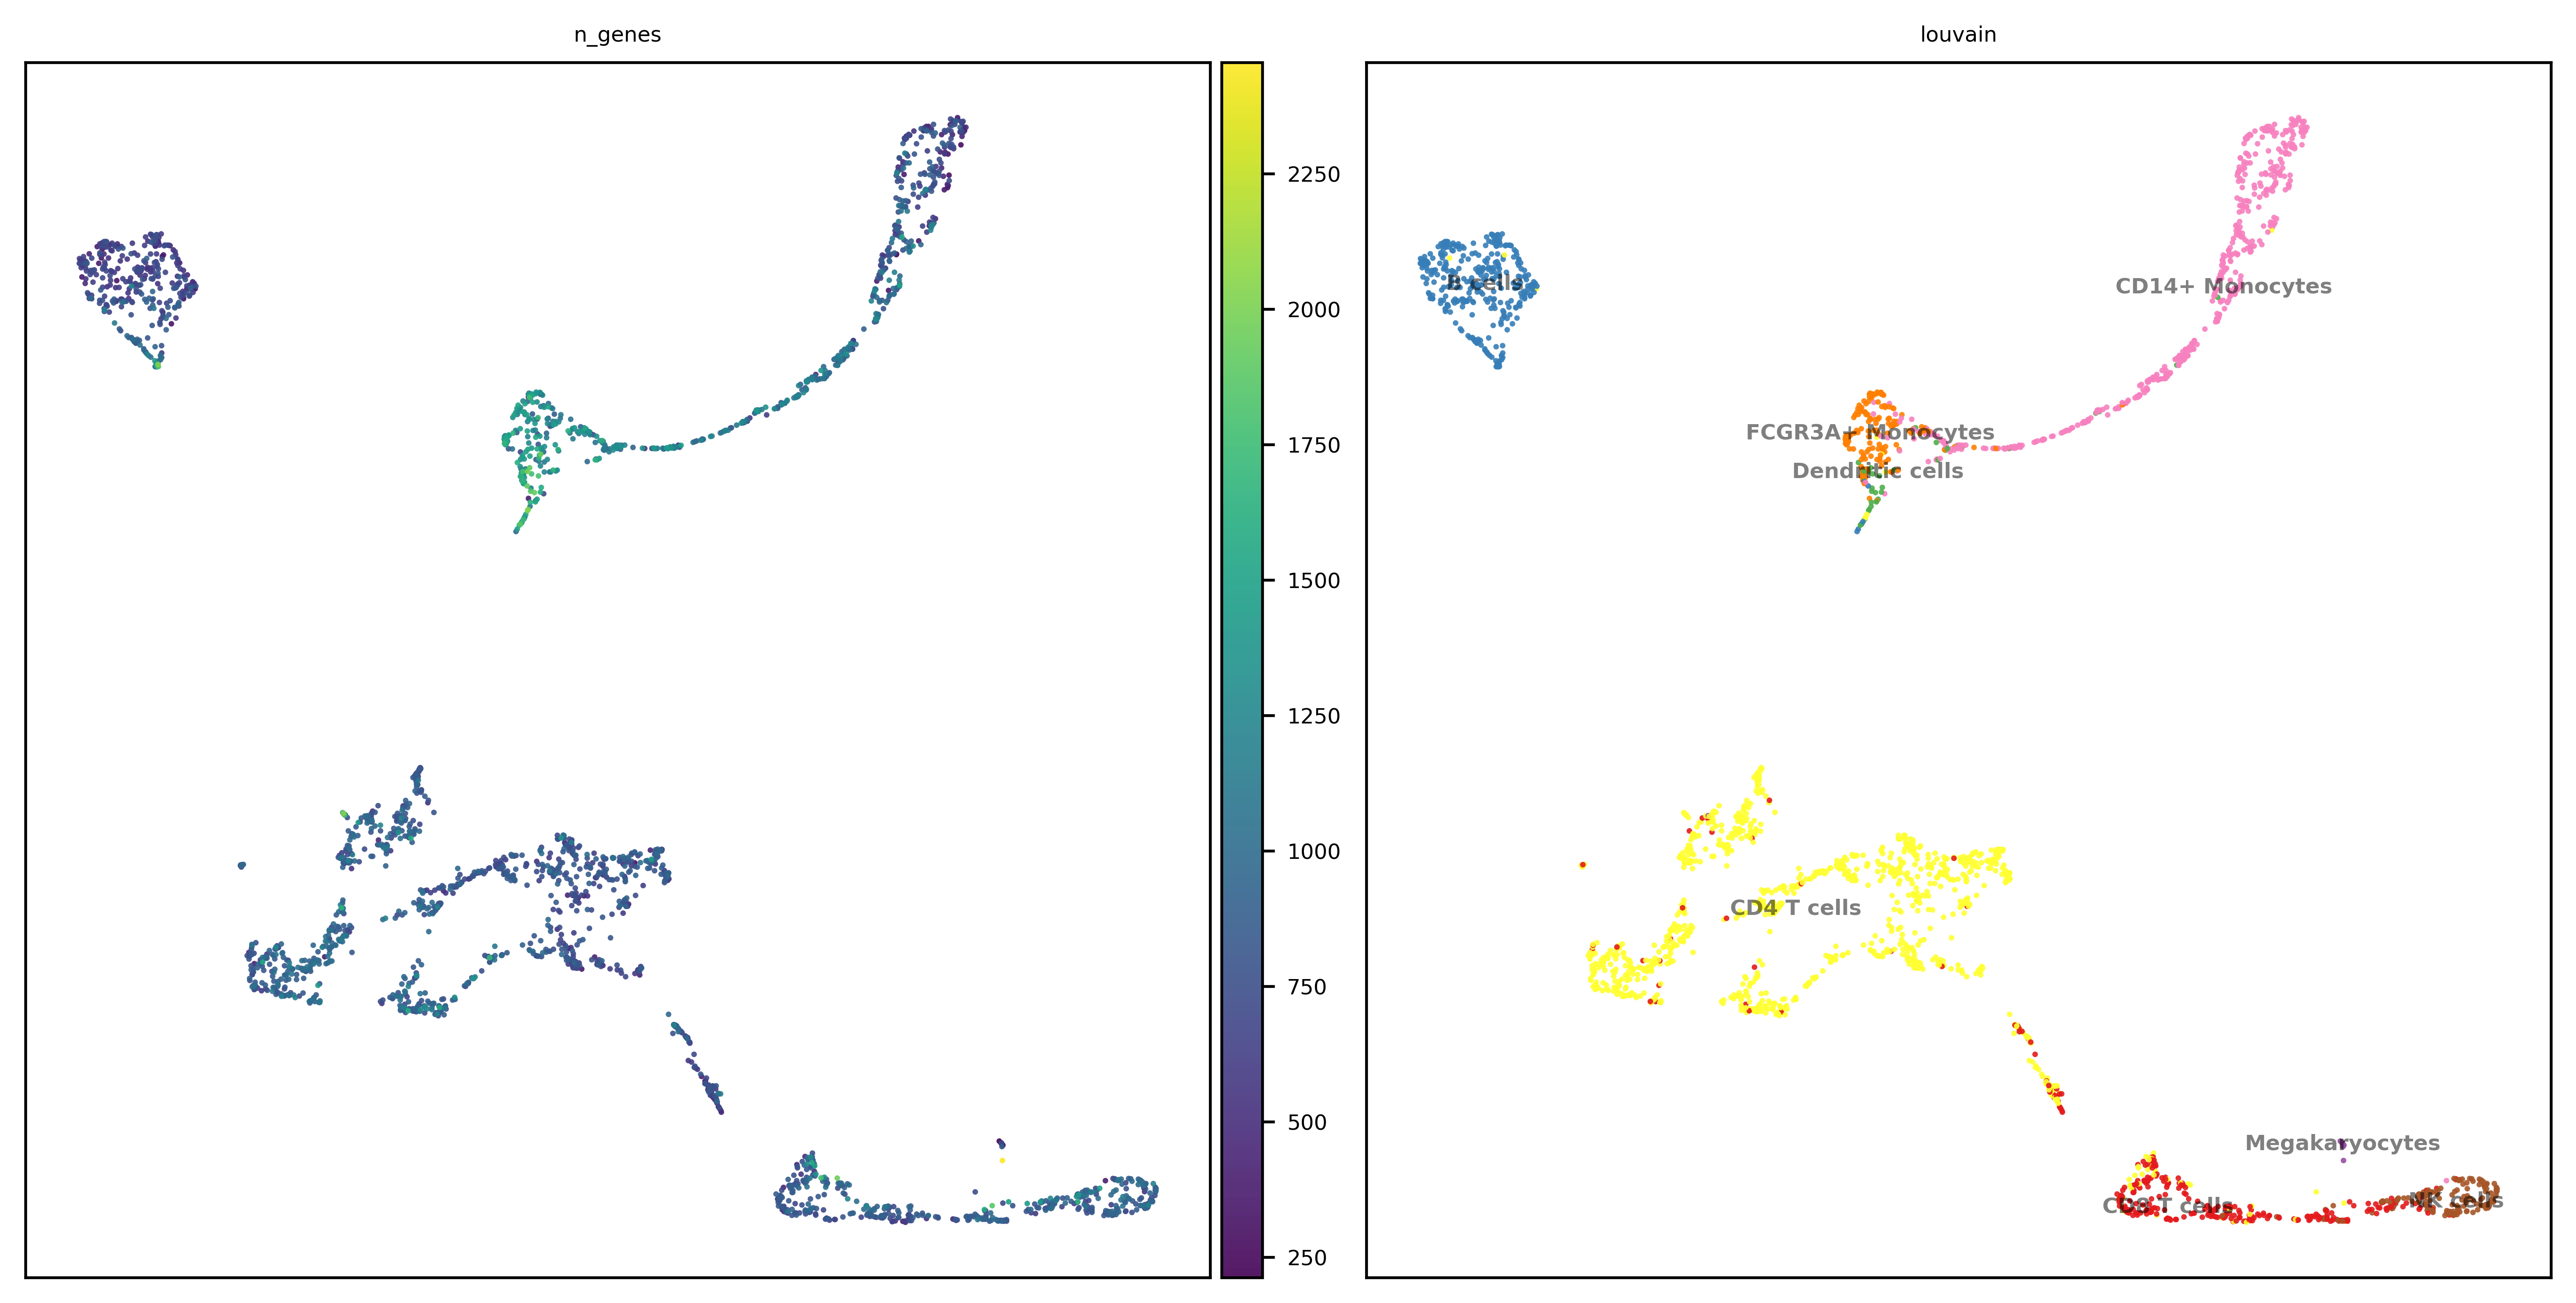

In [3]:
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')

# Plot the UMAP embeddings
color_by = ['n_genes', 'louvain'] # Choose which variables you want to visualize
ccd.pl.plot_embedding(
    adata, basis='Concord_UMAP', color_by=color_by, figsize=(10, 5), dpi=600, ncols=2, font_size=6, point_size=10, legend_loc='on data',
    save_path='Concord_UMAP.png'
)

The latent space produced by CONCORD often capture complex biological structures that may not be fully visualized in 2D projections. We recommend exploring the latent space using a 3D UMAP to more effectively capture and examine the intricacies of the data. For example:

In [4]:
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP_3D', n_components=3, n_neighbors=15, min_dist=0.1, metric='euclidean')

# Plot the 3D UMAP embeddings
col = 'louvain'
fig = ccd.pl.plot_embedding_3d(
    adata, basis='Concord_UMAP_3D', color_by=col, 
    save_path='Concord_UMAP_3D.html',
    point_size=3, opacity=0.8, width=1500, height=1000
)